In this first box we're just simply importing in all of the modules that are being used and ensuring we are in the right directory to get our calibration files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
import os

cwd = os.getcwd()
if cwd[-5:] != "Lab_3":
    os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_3")

In this next box we're importing in all of the calibration files we're going to need for data reduction. We have dark frames specifically for merak (actually taken with a 2 min exposure) that we can also use for the flat fields and the lamp spectrum, and then the dark frames we use for the galaxies. We are also importing the flat field images so that we can subtract any dark current from it.

In [2]:
# Importing the dark frames that were taken for Merak

two_min_dark_prefix = "lab_3_dark_5_min.0000000"
two_min_dark_suffix = ".DARK.FIT"
two_min_dark_data = []
two_min_start = 0
two_min_end = 4

for i in range(two_min_start, two_min_end+1, 1):
    filename = two_min_dark_prefix + str(i) + two_min_dark_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    two_min_dark_data.append(image_data)
        
# Importing the dark frames that were taken for the galaxies and will be used on flat fields (same exposure times)        
gal_dark_prefix = "lab_3_dark_25_min.0000000"
gal_dark_suffix = ".DARK.FIT"
gal_dark_data = []
gal_start = 0
gal_end = 1

for i in range(gal_start, gal_end+1, 1):
    filename = gal_dark_prefix + str(i) + gal_dark_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    gal_dark_data.append(image_data)
        
# lamp_data = []
# with fits.open('calibration_images/lab_3_ne_lamp.00000000.FIT') as file:
#     plt.imshow(file[0].data, cmap='gray', vmax=9000)
#     plt.colorbar()
#     lamp_data.append(file[0].data)
    
    
# Importing the flat fields that were taken for our observations (same for all)
flat_prefix = "lab_3_flat_2_min.0000000"
flat_suffix = ".FIT"
flat_data = []
flat_start = 0
flat_end = 3

for i in range(flat_start, flat_end+1, 1):
    ind = str(i)
    filename = flat_prefix + str(i) + flat_suffix
    list = fits.open('calibration_images/'+filename)
    image_data = list[0].data
    flat_data.append(image_data)


Here we're just calculating the master dark frames for the 2 min and the 25 min dark frames. We're using the mean here rather than the median since there are not that many points to work with.

In [3]:
# Calculating the master dark frames for Merak and the Galaxies

two_min_master_dark = np.mean(two_min_dark_data, axis=0)
gal_master_dark = np.mean(gal_dark_data, axis=0)

In this box we're importing in all of the science images taken. Rather than having seperate sections to import in each set of images seperately, we are utilizing lists to open specified files in specified directories. We save each set of images within the list `total_data`, with each index representing each group of images. So `total_data[0]` refers to the merak images, and `total_data[0][0]` refers to the first image in the group of merak images.

In [4]:
names = ["lab_3_merak_2_mins.0000000", "lab_3_m51_25_min.0000000", "lab_3_m82_25_mins.0000000", "lab_3_ne_lamp.0000000", "lab_3_empty_25_mins.0000000"]
folder_names = ["merak_images", "m51_images", "m82_images", "calibration_images", "calibration_images"]

starts = [0, 1, 0, 0, 3]
ends = [4, 3, 2, 0, 5]
image_end = ".FIT"
melark_data = []
m51_data = []
m82_data = []
lamp_data = []
sky_data = []
total_data = [melark_data, m51_data, m82_data, lamp_data, sky_data]

j = 0
for image_prefix in names:
    for i in range(starts[j], ends[j]+1, 1):
        filename = image_prefix + str(i) + image_end
        list = fits.open(folder_names[j]+"/"+filename)
        image_data = list[0].data
        total_data[j].append(image_data)
    j += 1  

# print(min(total_data[1][0].flatten()))
# x = np.linspace(0, len(total_data[1][0].flatten()), num=len(total_data[1][0].flatten()))
# plt.plot(x, total_data[1][0].flatten())

# for i in range(len(total_data[1])):
#     x = np.linspace(0, len(total_data[1][i].flatten()), num=len(total_data[1][i].flatten()))
#     plt.plot(x, total_data[1][i].flatten())
#     plt.show()
    

Now we're taking our data and subtracting out the dark current for each image. The merak and lamp images correspond to `total_data[0]` and `total_data[3]`. So when we subtract from those in our loop we ensure we're using the two minute dark frame, while for the rest we subtract the 25 minute dark frame, i.e. `gal_master_dark`. We save the calibrated data in the list `calib_totals`.

We then separate `calib_totals` into the respective groups and also subtract the dark current from out flat field images as well. We also create a "master sky" image by using both the mean values and the median values. For all of the values in the two master sky images, if the value is less than 0.0 we set the value equal to the mean/median value. **We haven't done this for the individual science images yet, and we are unsure if we should be doing that or not.**

Finally we subtract the sky images from our calibrated sky images, using both the mean sky image and the median sky image seperately.

In [5]:
calib_totals = []
merak_final = []
m51_final = []
m82_final = []
lamp_final = []
sky_final = []

for j in range(0, 5):
    for i in range(0, len(total_data[j])):
        if j == 0 or j == 3:
            calib_totals.append(total_data[j][i]-two_min_master_dark)
        else:
            calib_totals.append(total_data[j][i]-gal_master_dark)

for i in range(0, len(calib_totals)):
    for j in range(0, 255):
        for k in range(0, 765):
            if calib_totals[i][j][k] < -500.:
                calib_totals[i][j][k] = np.median(calib_totals[i].flatten())

merak_final = calib_totals[0:5]
m51_final = calib_totals[5:8]
m82_final = calib_totals[8:11]
lamp_final = calib_totals[11:12]
sky_final = calib_totals[12:]
flat_final = flat_data - two_min_master_dark


sky_median = [np.median(sky_final, axis=0)]
sky_mean = [np.mean(sky_final, axis=0)]
total_sky_median = np.median(sky_median[0].flatten())
total_sky_mean = np.mean(sky_mean[0].flatten())

for i in range(0, 255):
    for j in range(0, 765):
        if sky_median[0][i][j] < 0.0:      
            sky_median[0][i][j] = total_sky_median
        if sky_mean[0][i][j] < 0.0:
            sky_mean[0][i][j] = total_sky_mean

merak_final_med = [merak_final[x] - (sky_median[0])/12.5 for x in range(0, len(merak_final))]
merak_final_mean = [merak_final[x] - (sky_mean[0])/12.5 for x in range(0, len(merak_final))]
m51_final_med = [m51_final[x] - sky_median for x in range(0, len(m51_final))]
m51_final_mean = [m51_final[x] - sky_mean for x in range(0, len(m51_final))]
m82_final_med = [m82_final[x] - sky_median for x in range(0, len(m82_final))]
m82_final_mean = [m82_final[x] - sky_mean for x in range(0, len(m82_final))]

# print(min(m51_final_med[0].flatten()))

# x = np.linspace(0, len(two_min_master_dark.flatten()), num=len(two_min_master_dark.flatten()))
# plt.plot(x, two_min_master_dark.flatten())
# plt.title("2 Minute Dark Frame Counts")
# plt.show()
# plt.title("Final Data for one m51 Image")
# plt.plot(x, m51_final_med[0].flatten())

# titles = ["Merak", "M51", "M82", "Lamp", "Sky"]
# for i in range(0, 15):
#     if i in range(0, 5):
#         k = 0
#     elif i in range(5, 8):
#         k=1
#     elif i in range(8, 11):
#         k=2
#     elif i == 11:
#         k=3
#     elif i >= 12:
#         k=4
#     title = titles[k]
#     x = np.linspace(0, len(calib_totals[i].flatten()), num=len(calib_totals[i].flatten()))
#     plt.plot(x, calib_totals[i].flatten())
#     plt.title(title)
#     plt.show()


Now we're switching directories into our **calibrated_fits_files** directory where we will be putting our calibrated files. We once again do this through the use of lists.

In [6]:
cwd = os.getcwd()
if cwd[-25:] != "calibrated_fits_files":
    os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_3/calibrated_fits_files")
    cwd = os.getcwd()
target_names = ["merak_med.00", "merak_mean.00", "m51_med.00", "m51_mean.00", "m82_med.00", "m82_mean.00", "neon.00", "sky.00", "sky_med.00", "sky_mean.00", "flat.00"]
data = [merak_final_med, merak_final_mean, m51_final_med, m51_final_mean, m82_final_med, m82_final_mean, lamp_final, sky_final, sky_median, sky_mean, flat_data]
j=0
if os.path.exists("merak_med.000.FIT") != True:
    for image_prefix in target_names:
        image_suffix = ".FIT"
        for i in range(0, len(data[j])):
            hdu = fits.PrimaryHDU(data[j][i])
            filename = image_prefix + str(i) + image_suffix
            hdu.writeto(filename, overwrite=True)
        j += 1
        
# for j in range(0, len(data)):  
#     for i in range(0, len(data[j])):
#         x = np.linspace(0, len(data[j][i].flatten()), num=len(data[j][i].flatten()))
#         plt.plot(x, data[j][i].flatten())
#         plt.show()

We're just using this to plot images to see how they look after we saved them.

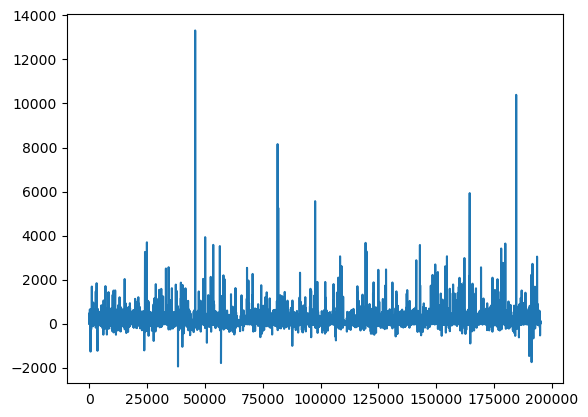

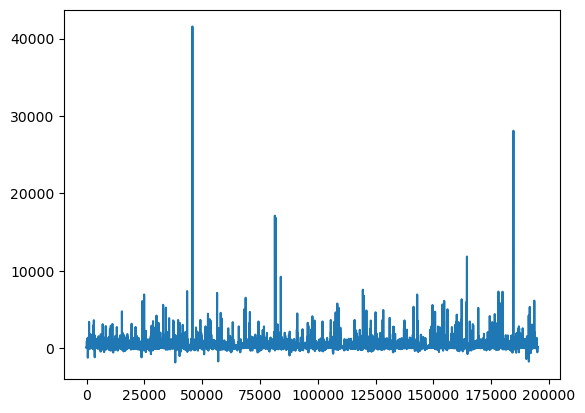

In [7]:
with fits.open('m51_mean.001.FIT') as file:
    data = file[0].data
    flat_data = data.flatten()
    x = np.linspace(0, len(flat_data), num=len(flat_data))
    plt.plot(x, flat_data)
    plt.show()

with fits.open('m51_mean.002.FIT') as file:
    data = file[0].data
    flat_data = data.flatten()
    x = np.linspace(0, len(flat_data), num=len(flat_data))
    plt.plot(x, flat_data)

## 50 um Flat Fields

Flat fields for 50um slit, used for galaxy spectra.

Text(0.5, 1.0, 'Full Spectrum Columns')

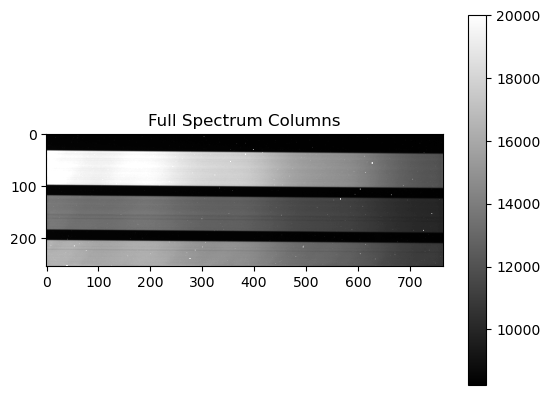

In [8]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

os.chdir("/Users/efrainmartinez/Downloads/SBU/SBU_Spring_2024_Semester/AST443/Labs/AST_443/Lab_3")

spectra_image = fits.open('calibrated_fits_files/flat.000.FIT')

data = spectra_image[0].data
plt.imshow(data,cmap='gray',vmax = 20000)
plt.colorbar()
plt.title('Full Spectrum Columns')

(70, 765)
53550


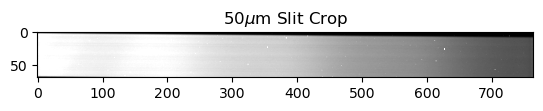

In [9]:
# Crop data to only include the top band (50um)

crop = data[30:100,:]
print(crop.shape)
plt.imshow(crop,cmap='gray',vmax = 20000)
plt.title(r'50$\mu$m Slit Crop')
print(crop.size)

In [10]:
flat_list = []

# find and open the Flat Fields and store them all in one list
file_prefix = "flat.00"
file_end = ".FIT"
pixel_data = [None]*4

for i in range(0, 4, 1):
    filename = file_prefix + str(i) + file_end
    print(filename)
    list = fits.open('../Lab_3/calibrated_fits_files/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data[30:100,:]


# open a 2d list to store median values
median_values = np.zeros((70, 765)) 

# run through and calculate the median value for each pixel
for i in range(0, 70):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,4)]
        median_values[i][j] = np.median(values)

flat.000.FIT
flat.001.FIT
flat.002.FIT
flat.003.FIT


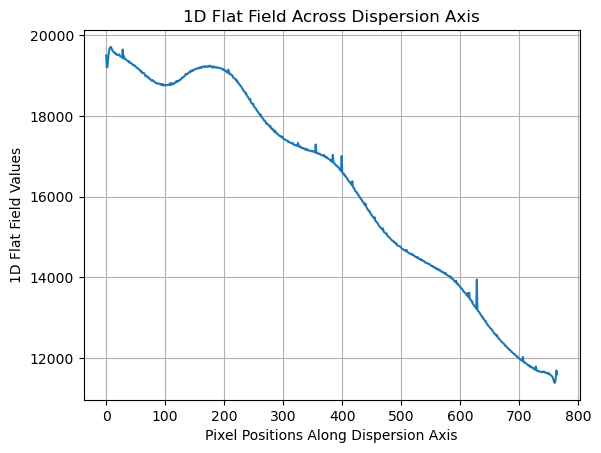

In [11]:
# Calculate the 1D flat field values by averaging along the y-axis
flat_field_1d = np.mean(median_values, axis=0)

# Plotting the 1D flat field values against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field_1d)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('1D Flat Field Across Dispersion Axis')
plt.grid(True)
plt.show()

 [astropy.modeling.fitting]


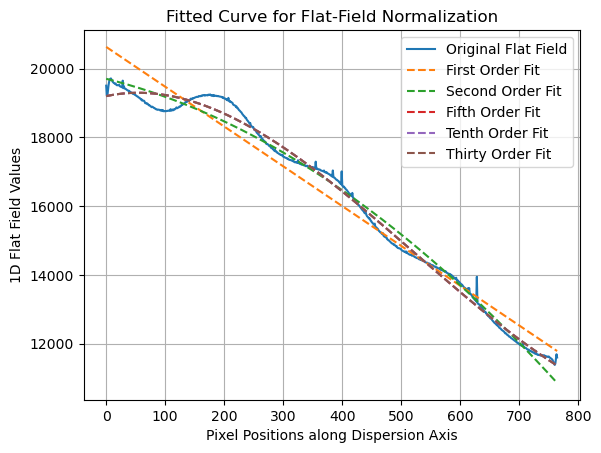

In [12]:
from astropy.modeling import models, fitting

# Pixel positions along the dispersion axis
dispersion_axis = np.arange(765)  #765 is the length of the dispersion axis

# Initialize various polynomial models for fitting
first_order = models.Polynomial1D(degree=1)
second_order = models.Polynomial1D(degree=2)
fifth_order = models.Polynomial1D(degree=5)
tenth_order = models.Polynomial1D(degree=10)
thirty_order = models.Polynomial1D(degree=30)

# Initialize a fitting algorithm
fitter = fitting.LinearLSQFitter()

# Fit the models to the 1D flat-field spectrum
first_fit = fitter(first_order, dispersion_axis, flat_field_1d)
second_fit = fitter(second_order, dispersion_axis, flat_field_1d)
fifth_fit = fitter(fifth_order, dispersion_axis, flat_field_1d)
tenth_fit = fitter(tenth_order, dispersion_axis, flat_field_1d)
thirty_fit = fitter(thirty_order, dispersion_axis, flat_field_1d)

# Generate the fits using the fitted model
first_fit_curve = first_fit(dispersion_axis)
second_fit_curve = second_fit(dispersion_axis)
fifth_fit_curve = fifth_fit(dispersion_axis)
tenth_fit_curve = tenth_fit(dispersion_axis)
thirty_fit_curve = thirty_fit(dispersion_axis)


# Plot the original flat-field and the fitted curves
plt.plot(dispersion_axis, flat_field_1d, label='Original Flat Field')
plt.plot(dispersion_axis, first_fit(dispersion_axis), label='First Order Fit', linestyle='--')
plt.plot(dispersion_axis, second_fit(dispersion_axis), label='Second Order Fit', linestyle='--')
plt.plot(dispersion_axis, fifth_fit(dispersion_axis), label='Fifth Order Fit', linestyle='--')
plt.plot(dispersion_axis, tenth_fit(dispersion_axis), label='Tenth Order Fit', linestyle='--')
plt.plot(dispersion_axis, thirty_fit(dispersion_axis), label='Thirty Order Fit', linestyle='--')

plt.xlabel('Pixel Positions along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('Fitted Curve for Flat-Field Normalization')
plt.legend()
plt.grid(True)
plt.show()

# Divide the 2D flat-field by the fits to obtain the normalized flat-field
first_normalized_flat_field = median_values / first_fit_curve
second_normalized_flat_field = median_values / second_fit_curve
fifth_normalized_flat_field = median_values / fifth_fit_curve
tenth_normalized_flat_field = median_values / tenth_fit_curve
thirty_normalized_flat_field = median_values / thirty_fit_curve

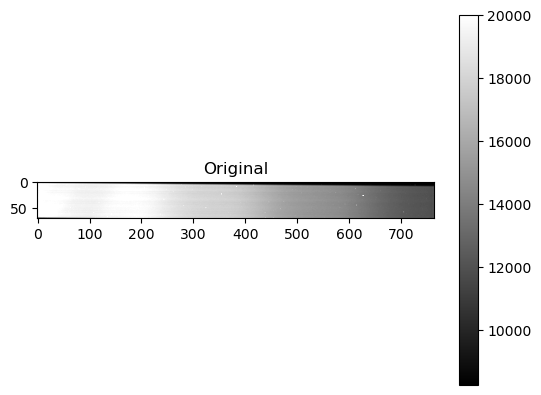

In [13]:
plt.imshow(crop,cmap='gray',vmax = 20000)
plt.title('Original')
plt.colorbar()

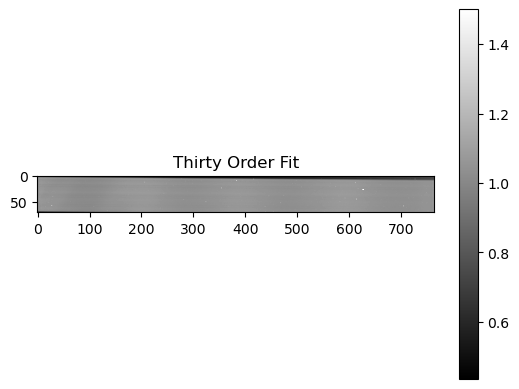

In [14]:
plt.imshow(thirty_normalized_flat_field,cmap='gray',vmax = 1.5)
plt.title('Thirty Order Fit')
plt.colorbar()

## 25 um Flat Fields

Used for Merak analysis

In [15]:
flat25_list = []

# find and open the Flat Fields and store them all in one list
file_prefix = "flat.00"
file_end = ".FIT"
pixel_data = [None]*4

for i in range(0, 4, 1):
    filename = file_prefix + str(i) + file_end
    print(filename)
    list = fits.open('../Lab_3/calibrated_fits_files/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data[110:195,:]


# open a 2d list to store median values
median25_values = np.zeros((75, 765)) 

# run through and calculate the median value for each pixel
for i in range(0, 75):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,4)]
        median25_values[i][j] = np.median(values)

flat.000.FIT
flat.001.FIT
flat.002.FIT
flat.003.FIT


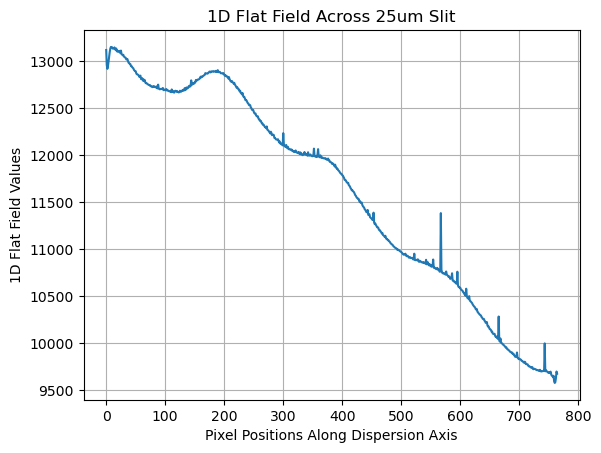

In [16]:
# Calculate the 1D flat field values by averaging along the y-axis
flat25_field_1d = np.mean(median25_values, axis=0)

# Plotting the 1D flat field values against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat25_field_1d)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('1D Flat Field Across 25um Slit')
plt.grid(True)
plt.show()

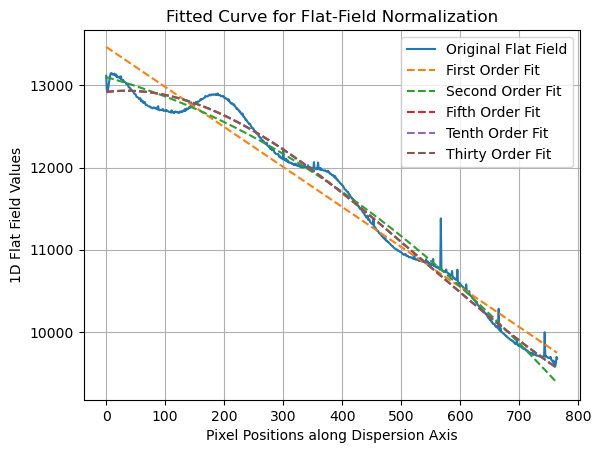

In [17]:
from astropy.modeling import models, fitting

# Pixel positions along the dispersion axis
dispersion_axis = np.arange(765)  #765 is the length of the dispersion axis

# Initialize various polynomial models for fitting
first_order = models.Polynomial1D(degree=1)
second_order = models.Polynomial1D(degree=2)
fifth_order = models.Polynomial1D(degree=5)
tenth_order = models.Polynomial1D(degree=10)
thirty_order = models.Polynomial1D(degree=30)

# Initialize a fitting algorithm
fitter = fitting.LinearLSQFitter()

# Fit the models to the 1D flat-field spectrum
first25_fit = fitter(first_order, dispersion_axis, flat25_field_1d)
second25_fit = fitter(second_order, dispersion_axis, flat25_field_1d)
fifth25_fit = fitter(fifth_order, dispersion_axis, flat25_field_1d)
tenth25_fit = fitter(tenth_order, dispersion_axis, flat25_field_1d)
thirty25_fit = fitter(thirty_order, dispersion_axis, flat25_field_1d)

# Generate the fits using the fitted model
first25_fit_curve = first25_fit(dispersion_axis)
second25_fit_curve = second25_fit(dispersion_axis)
fifth25_fit_curve = fifth25_fit(dispersion_axis)
tenth25_fit_curve = tenth25_fit(dispersion_axis)
thirty25_fit_curve = thirty25_fit(dispersion_axis)


# Plot the original flat-field and the fitted curves
plt.plot(dispersion_axis, flat25_field_1d, label='Original Flat Field')
plt.plot(dispersion_axis, first25_fit(dispersion_axis), label='First Order Fit', linestyle='--')
plt.plot(dispersion_axis, second25_fit(dispersion_axis), label='Second Order Fit', linestyle='--')
plt.plot(dispersion_axis, fifth25_fit(dispersion_axis), label='Fifth Order Fit', linestyle='--')
plt.plot(dispersion_axis, tenth25_fit(dispersion_axis), label='Tenth Order Fit', linestyle='--')
plt.plot(dispersion_axis, thirty25_fit(dispersion_axis), label='Thirty Order Fit', linestyle='--')

plt.xlabel('Pixel Positions along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('Fitted Curve for Flat-Field Normalization')
plt.legend()
plt.grid(True)
plt.show()

# Divide the 2D flat-field by the fits to obtain the normalized flat-field
first25_normalized_flat_field = median25_values / first25_fit_curve
second25_normalized_flat_field = median25_values / second25_fit_curve
fifth25_normalized_flat_field = median25_values / fifth25_fit_curve
tenth25_normalized_flat_field = median25_values / tenth25_fit_curve
thirty25_normalized_flat_field = median25_values / thirty25_fit_curve

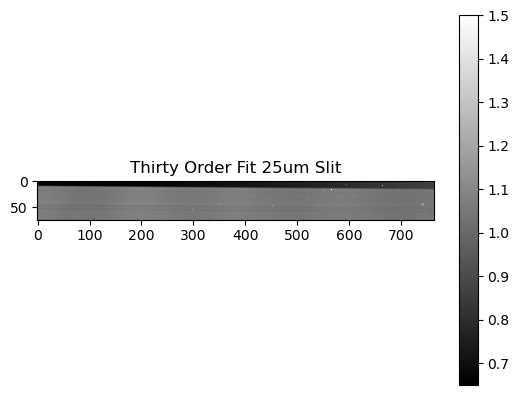

In [18]:
plt.imshow(thirty25_normalized_flat_field,cmap='gray',vmax=1.5)
plt.title('Thirty Order Fit 25um Slit')
plt.colorbar()

## Arc Lamp

Below is the full arc lamp spectra:

Text(0.5, 1.0, 'Arc Lamp Spectra')

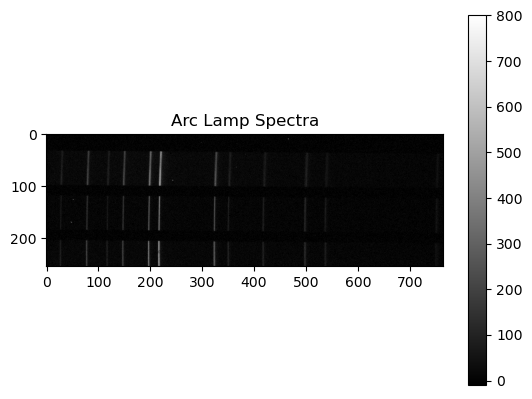

In [19]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

spectra = fits.open('calibrated_fits_files/neon.000.FIT')

spectra_data = spectra[0].data 
plt.imshow(spectra_data,cmap='gray',vmin = -10, vmax = 800)
plt.colorbar()
plt.title('Arc Lamp Spectra')

(70, 765)


Text(0.5, 1.0, 'Crop of 50$\\mu$m Slit')

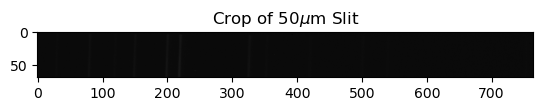

In [20]:
spectra_crop = spectra_data[30:100,:]
print(spectra_crop.shape)
plt.imshow(spectra_crop,cmap='gray',vmax=8800)
plt.title(r'Crop of 50$\mu$m Slit')

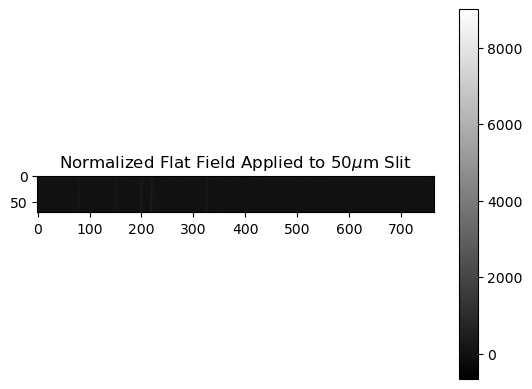

In [21]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
normal = spectra_crop / thirty_normalized_flat_field

plt.imshow(normal,cmap='gray',vmax= 9000)
plt.title(r'Normalized Flat Field Applied to 50$\mu$m Slit')
plt.colorbar()

## Dispersion Axis: Pixel --> Wavelength

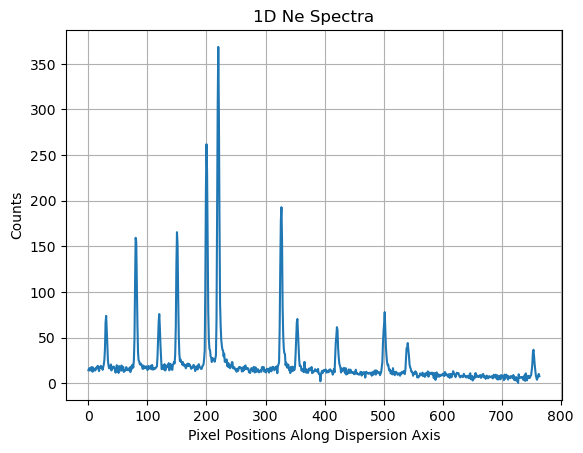

In [22]:
# Calculate the 1D spectra by averaging along the y-axis
flat_field = np.mean(normal, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D Ne Spectra')
plt.grid(True)
plt.show()

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                c1        
    ----------------- ------------------
    6186.767850650794 0.9813911306273252


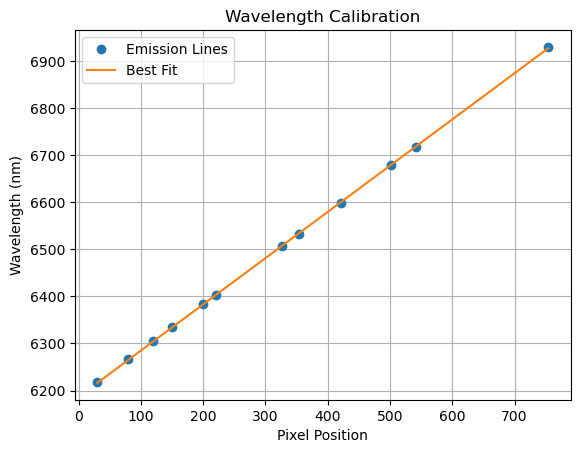

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.modeling import models, fitting

# Find peaks corresponding to known_wavelengths
peaks, _ = find_peaks(flat_field, height=35)

# Define the pixel positions of identified peaks

peaks = peaks.tolist()
# peaks.pop(10) # Remove double peak around pixel 540 
pixel_positions = peaks

# Known Neon spectrum emission lines provied by https://www.atomtrace.com/elements-database/element/10
known_wavelengths = [6217.28, 6266.49, 6304.79, 6334.43, 6382.99, 6402.25, 6506.53, 6532.88, 6598.95, 6678.28, 6717.04, 6929.47]


# Define the model for fitting
linear_model = models.Polynomial1D(degree=1)

# Perform the fitting
fitter = fitting.LinearLSQFitter()
best_fit = fitter(linear_model, pixel_positions, known_wavelengths)


# Plot the data and the best-fit line
plt.plot(pixel_positions, known_wavelengths, 'o', label='Emission Lines')
plt.plot(pixel_positions, best_fit(pixel_positions), label='Best Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Calibration')
plt.grid(True)
plt.legend()

# Display the fit parameters
print(best_fit)
plt.show()


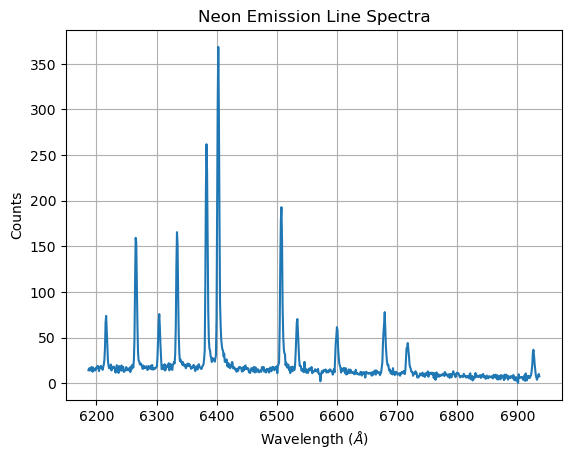

In [24]:
# Using best fit equation, adjust x-axis from pixels to nm
pixels = np.arange(765) 
wavelength_axis = 6186.767850650795 + 0.9813911306273253*pixels

plt.plot(wavelength_axis, flat_field)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Counts')
plt.title('Neon Emission Line Spectra')

#Add labels for stronger emission lines
#plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)


plt.grid(True)
plt.show()

## Merak

Text(0.5, 1.0, 'Merak Spectra')

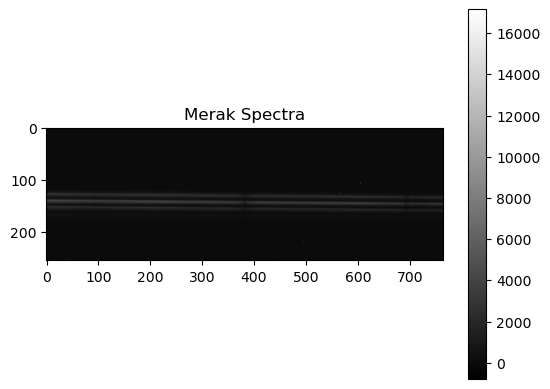

In [25]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

#One of the Merak FITS
merak_spec = fits.open('calibrated_fits_files/merak_mean.000.FIT',vmin = -10, vmax = 100)

merak_spec_data = merak_spec[0].data 
plt.imshow(merak_spec_data,cmap='gray')
plt.colorbar()
plt.title('Merak Spectra')

(70, 765)
53550


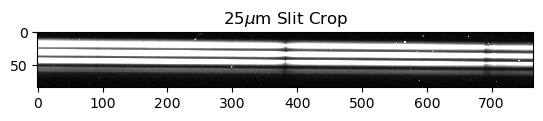

In [26]:
#Crop data to only include the middle band (25um)

merak_crop = merak_spec_data[110:195,:]
print(crop.shape)
plt.imshow(merak_crop,cmap='gray',vmin = -10, vmax = 1000)
plt.title(r'25$\mu$m Slit Crop')
print(crop.size)

In [27]:
merak_data = []

# find and open the Flat Fields and store them all in one list
file_prefix = "merak_mean.00"
file_end = ".FIT"
pixel_data = [None]*5

for i in range(0, 5):
    filename = file_prefix + str(i) + file_end
    print(filename, i)
    list = fits.open('../Lab_3/calibrated_fits_files/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data[110:195,:]


# open a 2d list to store median values
merak_median_values = np.zeros((75, 765)) 

# run through and calculate the median value for each pixel
for i in range(0, 75):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,5)]
        merak_median_values[i][j] = np.median(values)

merak_mean.000.FIT 0
merak_mean.001.FIT 1
merak_mean.002.FIT 2
merak_mean.003.FIT 3
merak_mean.004.FIT 4


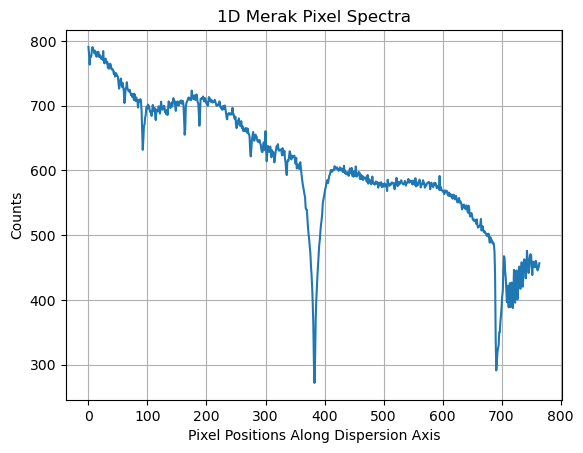

In [28]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
science_merak = merak_median_values / thirty25_normalized_flat_field

# Calculate the 1D spectra by averaging along the y-axis
merak_tot = np.mean(science_merak, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, merak_tot)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D Merak Pixel Spectra')
plt.grid(True)
plt.show()

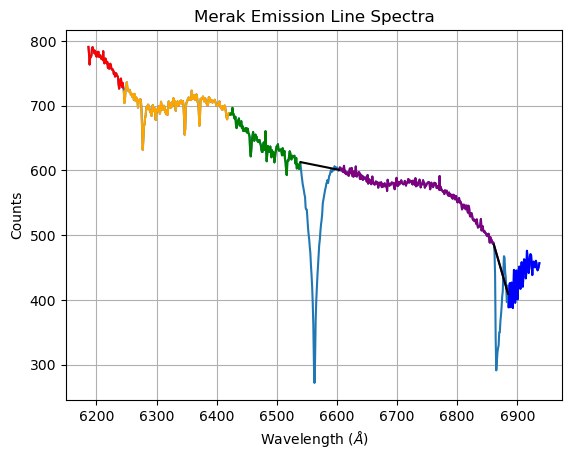

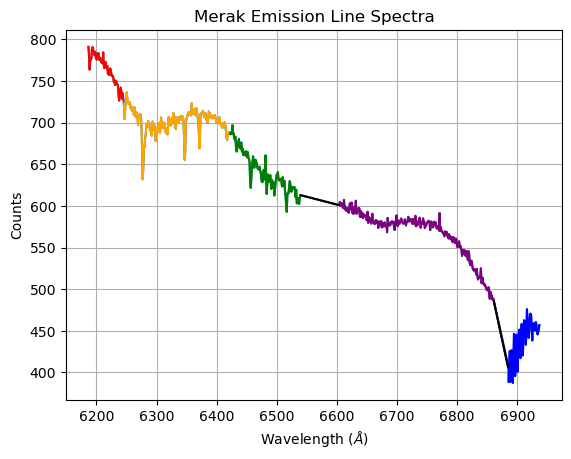

In [29]:
merak_og = merak_tot[:]
for i in range(0, 2):
    # Using best fit equation, adjust x-axis from pixels to nm
    plt.plot(wavelength_axis, merak_tot)
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel('Counts')
    plt.title('Merak Emission Line Spectra')

    #Add labels for stronger emission lines
    #plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)

    
    wavelength_axis_og = wavelength_axis[:]
    if str(type(merak_tot)) != "<class 'list'>":
        merak_tot = merak_tot.tolist()
        wavelength_axis = wavelength_axis.tolist()

    start = 0
    end = 60
    start1 = end
    end1 = 240
    start2 = end1
    end2 = 360
    start3 = end2 + 65
    end3 = 712
    start4 = end3

    midstart = end2
    midend = start3

    s1 = 360
    e1 = 425
    s2 = 687
    e2 = 712

    # del merak_tot[s2:e2]
    # del wavelength_axis[s2:e2]



    m1 = (merak_tot[start3] - merak_tot[end2-1]) / (wavelength_axis[start3] - wavelength_axis[end2-1])
    b1 = merak_tot[end2-1]
    y_line1 = [m1*(x-wavelength_axis[end2-1]) + b1 for x in np.linspace(wavelength_axis[end2-1], wavelength_axis[start3], 65)]
    merak_tot[s1:e1] = y_line1[:]

    m2 = (merak_tot[e2-1] - merak_tot[s2]) / (wavelength_axis[e2-1] - wavelength_axis[s2])
    b2 = merak_tot[s2]
    y_line2 = [m2*(x-wavelength_axis[s2]) + b2 for x in np.linspace(wavelength_axis[s2], wavelength_axis[e2], 25)]
    merak_tot[s2:e2] = y_line2[:]

    # plt.plot(wavelength_axis[s2:e2], merak_tot[s2:e2], c='blue')
    plt.plot(wavelength_axis[start:end], merak_tot[start:end], c='r')
    plt.plot(wavelength_axis[start1:end1], merak_tot[start1:end1], c='orange')
    plt.plot(wavelength_axis[start2:end2], merak_tot[start2:end2], c='green')
    plt.plot(wavelength_axis[start3:end3], merak_tot[start3:end3], c='purple')
    plt.plot(wavelength_axis[start4:], merak_tot[start4:], c='blue')
    plt.plot(wavelength_axis[midstart:midend], merak_tot[midstart:midend], c='black')
    plt.plot(wavelength_axis[s2:e2], merak_tot[s2:e2], c='black')

    plt.grid(True)
    plt.show()

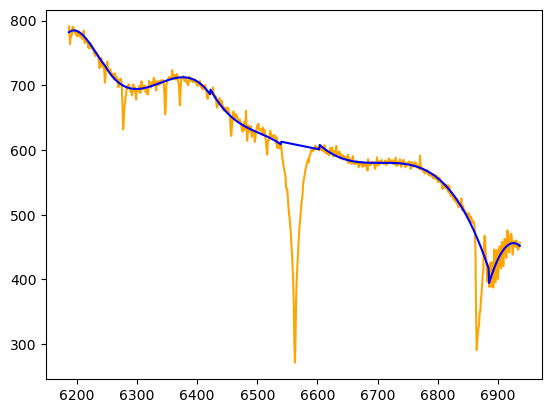

In [30]:
from scipy.optimize import curve_fit
import csv

def three(x, a, b, c, d):
    return a*(x)**3 + b*(x)**2 + c*(x) + d

def four(x, a, b, c, d, e):
    return a*(x)**4 + b*(x)**3 + c*(x)**2 + d*(x) + e

def quad(x, a, b, c):
    return a*((x)**2) + b*(x) + c

total_points = []
xplot = []
yplot = []
x_nums = [wavelength_axis[start:end], wavelength_axis[start1:end1], wavelength_axis[start2:end2],
         wavelength_axis[midstart:midend], wavelength_axis[start3:end3], wavelength_axis[start4:]]
y_nums = [merak_tot[start:end], merak_tot[start1:end1], merak_tot[start2:end2], merak_tot[midstart:midend], merak_tot[start3:end3], merak_tot[start4:]]

for i in range(0, 6):

    xs = x_nums[i]
    ys = y_nums[i]
    
    if i == 2 or i ==4:
        param, cov = curve_fit(four, xs, ys)
        a, b, c, d, e = param
    
        nums = [four(x, a, b, c, d, e) for x in xs]
        
    elif i == 5:
        param, cov = curve_fit(quad, xs, ys)
        a, b, c = param
        nums = [quad(x, a, b, c) for x in xs]
    elif i == 3:
        nums = ys
    else:
        param, cov = curve_fit(three, xs, ys)
        a, b, c, d = param
    
        nums = [three(x, a, b, c, d)+3 for x in xs]
    
    for x_val, y_val in zip(xs, ys):
        xplot.append(x_val)
        yplot.append(y_val)
    for values in nums:
        total_points.append(values)


plt.plot(wavelength_axis_og, merak_og, color="orange")
plt.plot(xplot, total_points, c='blue')

header = ['wavelength', 'fit numbers']
data_vals = zip(xplot, total_points)

with open('sensitivity_nums.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(data_vals)

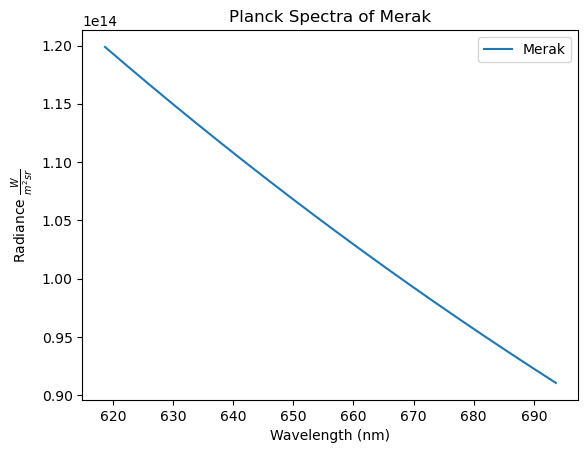

In [31]:
#Some old code I made a while ago for fun, see https://github.com/brady-ryan/planck_spectrum

import numpy as np
import matplotlib.pyplot as plt

h = 6.626e-34
c = 3.0e+8
k = 1.38e-23
i = 620
j = 700

class Planck:

    def __init__(self,T,name):
        self.T = T
        self.name = name
        self.wls = np.linspace(6186.767850650795e-10, 6936.550674450071e-10, 765)

    def B(self,wl,T):
        a = 2.*h*c**2
        b = (h*c)/(wl*k*T)
        ans = a/((wl**5)*(np.exp(b)-1.))
        return ans
    
    def plot(self):
        xs = self.wls*1e9
        ys = self.B(self.wls,self.T)
        plt.plot(xs,ys,label=f'{self.name}')
        plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
        plt.xlabel(r"Wavelength (nm)")
        plt.title(r"Planck Spectra of Merak")
        #plt.legend()

    def crop_plot(self):
        xs = self.wls*1e9
        ys = self.B(self.wls,self.T)
        x_bound = xs[:] * 10
        y_bound = ys[:] * 10
        return x_bound, y_bound

 
merak = Planck(9377,'Merak')

merak.plot()

xcrop, ycrop = merak.crop_plot()


plt.legend()
plt.show()

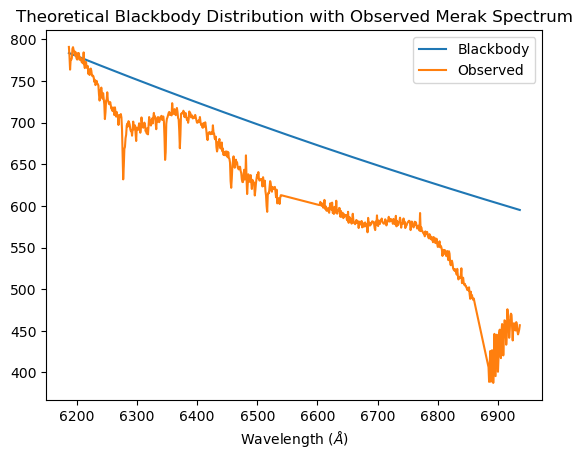

In [32]:
#Comparing the Merak spectra with the theoretical Planck spectra

s = 1.53e12

plt.plot(xcrop,ycrop/s,label='Blackbody')
plt.plot(wavelength_axis, merak_tot,label='Observed')
plt.xlabel(r'Wavelength ($\AA$)')
plt.title('Theoretical Blackbody Distribution with Observed Merak Spectrum')
plt.legend()

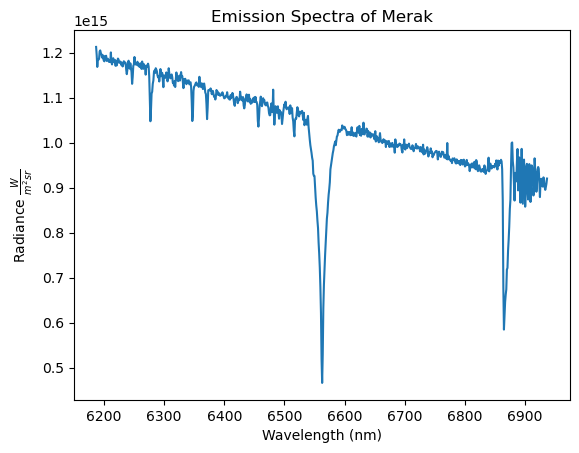

In [33]:
scales = ycrop / total_points

merak_tot_scaled = merak_og * scales
plt.plot(wavelength_axis, merak_tot_scaled)
plt.title("Emission Spectra of Merak")
plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
plt.xlabel(r"Wavelength (nm)")
plt.show()

## Sky

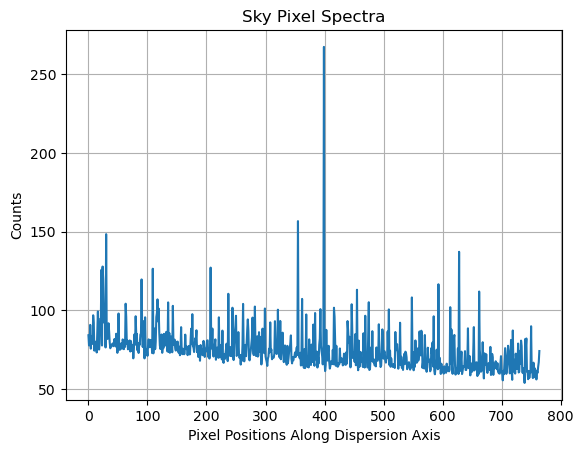

In [34]:
sky_spec = fits.open('calibrated_fits_files/sky_mean.000.FIT')

sky_spec_data = sky_spec[0].data 

sky_crop = sky_spec_data[30:100,:]

#Apply normalized flat field to arc lamp spectrum using the first order fit
science_sky = sky_crop / thirty_normalized_flat_field

# Calculate the 1D spectra by averaging along the y-axis
sky_tot = np.mean(science_sky, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, sky_tot)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('Sky Pixel Spectra')
plt.grid(True)
plt.show()

## M51

Text(0.5, 1.0, 'M51 Spectra')

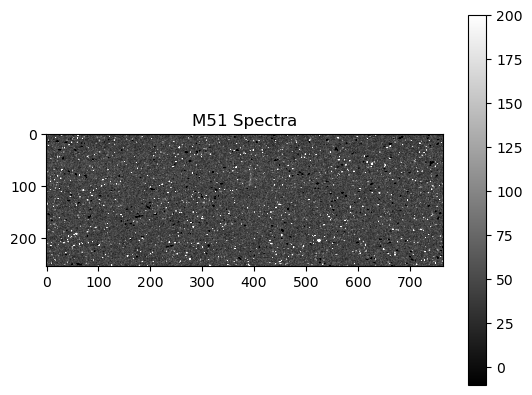

In [35]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

#One of the M51 FITS
m51_spec = fits.open('calibrated_fits_files/m51_mean.001.FIT')

m51_spec_data = m51_spec[0].data 

plt.imshow(m51_spec_data[0],cmap='gray', vmin=-10,vmax=200)
plt.colorbar()
plt.title('M51 Spectra')

Text(0.5, 1.0, '50$\\mu$m Slit Crop')

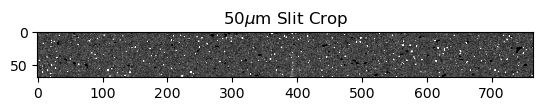

In [36]:
#Crop data to only include the top band (50um)

m51_crop = m51_spec_data[0][30:100,:]

plt.imshow(m51_crop,cmap='gray', vmin=-10,vmax=200)
plt.title(r'50$\mu$m Slit Crop')


In [37]:
m51_data = []

# find and open the Flat Fields and store them all in one list
file_prefix = "m51_mean.00"
file_end = ".FIT"
pixel_data = [None]*3

for i in range(0, 3):
    filename = file_prefix + str(i) + file_end
    print(filename, i)
    list = fits.open('../Lab_3/calibrated_fits_files/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data[0][30:100,:]


# open a 2d list to store median values
m51_median_values = np.zeros((70, 765)) 

# run through and calculate the median value for each pixel
for i in range(0, 70):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,3)]
        m51_median_values[i][j] = np.mean(values)

m51_mean.000.FIT 0
m51_mean.001.FIT 1
m51_mean.002.FIT 2


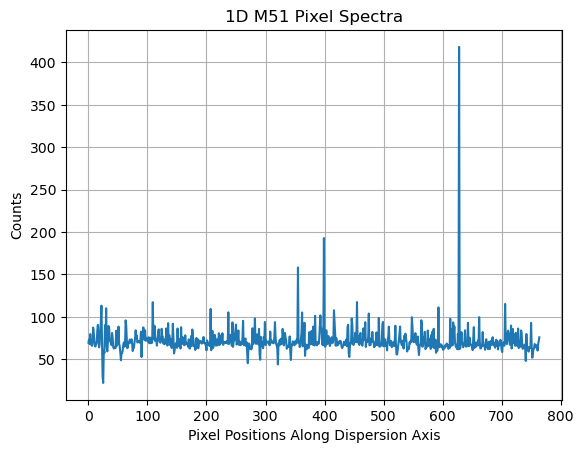

In [38]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
science_m51 = m51_median_values / thirty_normalized_flat_field

# Calculate the 1D spectra by averaging along the y-axis
m51_tot = np.mean(science_m51, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, m51_tot)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D M51 Pixel Spectra')
plt.grid(True)
plt.show()

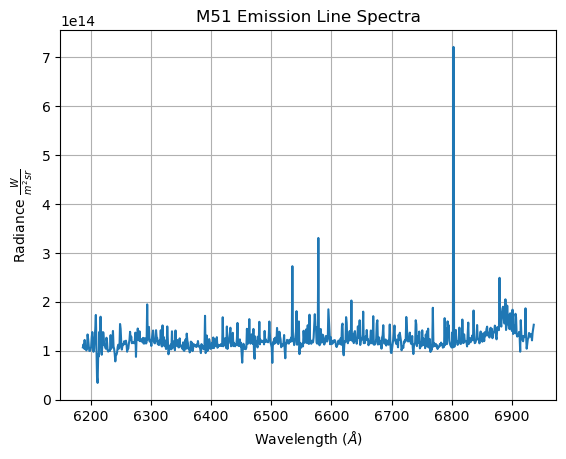

[355 399 628]
6535.161702023495
6578.3429117710975
6803.081480684755


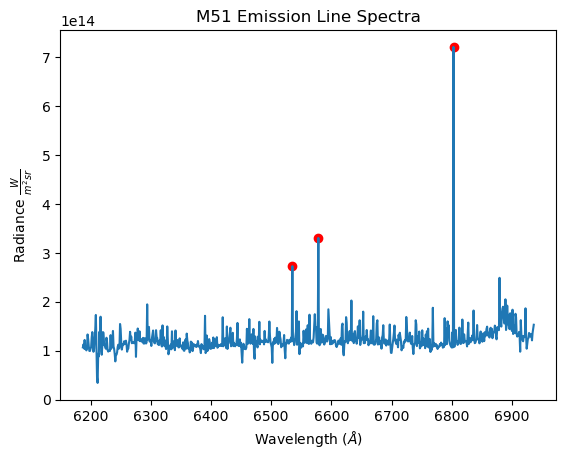

In [39]:
# Using best fit equation, adjust x-axis from pixels to nm

testm51 = m51_tot - sky_tot
plt.plot(wavelength_axis, m51_tot*scales)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
plt.title('M51 Emission Line Spectra')

#Add labels for stronger emission lines
#plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)


plt.grid(True)
plt.show()

plt.plot(wavelength_axis, m51_tot*scales)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
plt.title('M51 Emission Line Spectra')


peaks51, _ = find_peaks(m51_tot, height=150)

print(peaks51)

for p in peaks51:
    print(wavelength_axis[p])
    plt.scatter(wavelength_axis[p], m51_tot[p]*scales[p], c='r')

## M82

Text(0.5, 1.0, 'M82')

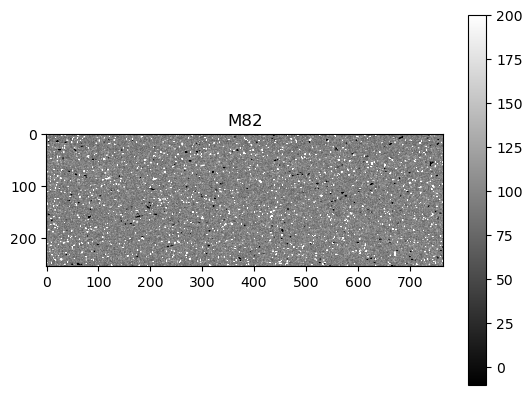

In [40]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

#One of the M82 FITS
m82_spec = fits.open('calibrated_fits_files/m82_mean.000.FIT')

m82_spec_data = m82_spec[0].data 
plt.imshow(m82_spec_data[0],cmap='gray', vmin = -10, vmax = 200)
plt.colorbar()
plt.title('M82')

In [41]:
m82_data = []

# find and open the Flat Fields and store them all in one list
file_prefix = "m82_mean.00"
file_end = ".FIT"
pixel_data = [None]*3

for i in range(0, 3):
    filename = file_prefix + str(i) + file_end
    print(filename, i)
    list = fits.open('../Lab_3/calibrated_fits_files/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data[0][30:100,:]


# open a 2d list to store median values
m82_median_values = np.zeros((70, 765)) #the cropped image is a 125 x 765 pixel array

# run through and calculate the median value for each pixel, 125 for y-axis and 765 for x-axis
for i in range(0, 70):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,3)]
        m82_median_values[i][j] = np.median(values)

m82_mean.000.FIT 0
m82_mean.001.FIT 1
m82_mean.002.FIT 2


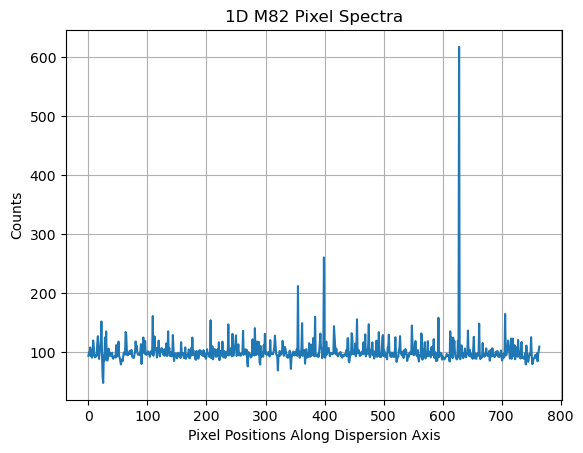

In [42]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
science_m82 = m82_median_values / thirty_normalized_flat_field

# Calculate the 1D spectra by averaging along the y-axis
m82_tot = np.mean(science_m82, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, m82_tot)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D M82 Pixel Spectra')
plt.grid(True)
plt.show()

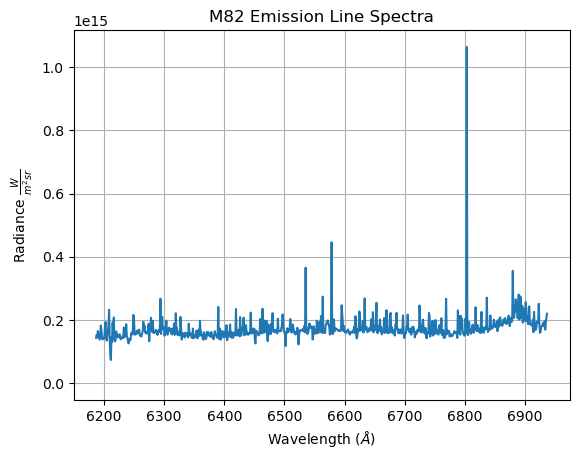

[355 399 628]
6535.161702023495
6578.3429117710975
6803.081480684755


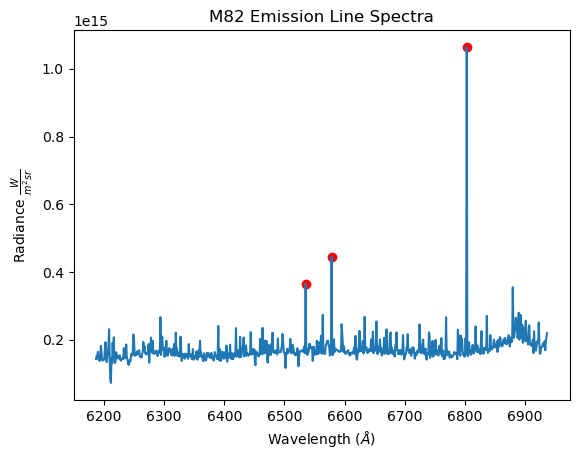

In [45]:
# Using best fit equation, adjust x-axis from pixels to nm

plt.plot(wavelength_axis, m82_tot*scales)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
plt.title('M82 Emission Line Spectra')

#Add labels for stronger emission lines
#plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)

plt.vlines(x=6562,ymin=0,ymax=500,color='green')
plt.grid(True)
plt.show()

plt.plot(wavelength_axis, m82_tot*scales)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r"Radiance $\frac{W}{m^2sr}$")
plt.title('M82 Emission Line Spectra')
peaks82, _ = find_peaks(m82_tot, height=200)

print(peaks82)

for p in peaks82:
    print(wavelength_axis[p])
    plt.scatter(wavelength_axis[p], m82_tot[p]*scales[p], c='r')

The stddev of the gaussian is 0.2730


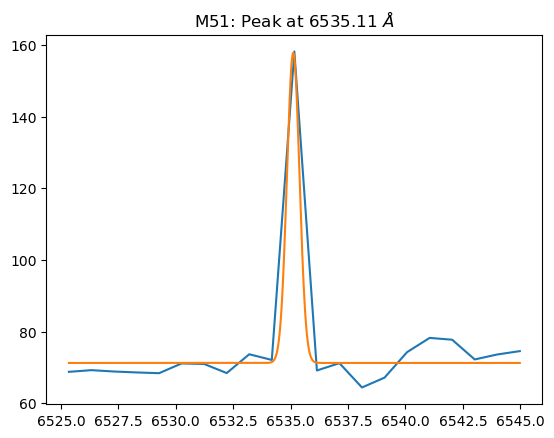

The stddev of the gaussian is 0.3081


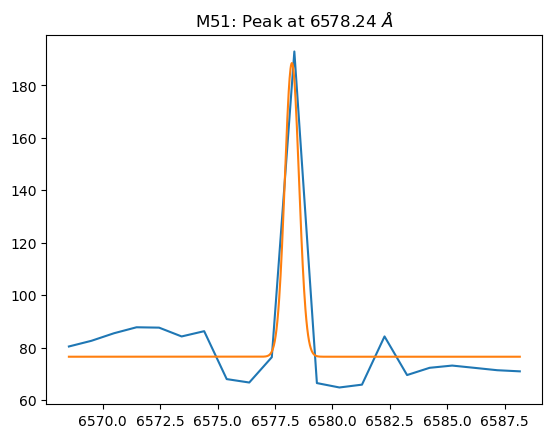

The stddev of the gaussian is 0.1238


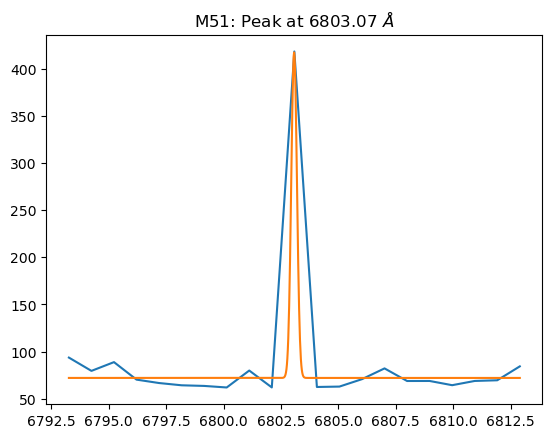

The stddev of the gaussian is 0.1208


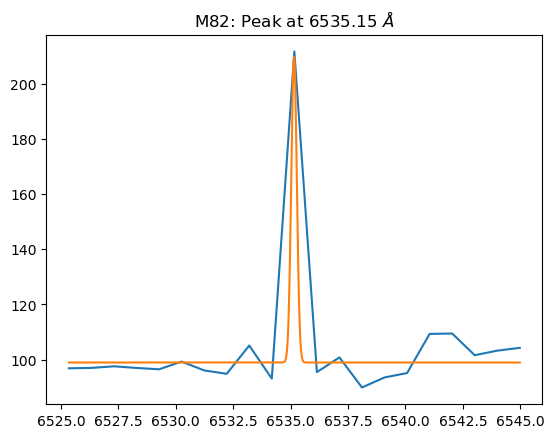

The stddev of the gaussian is 0.3143


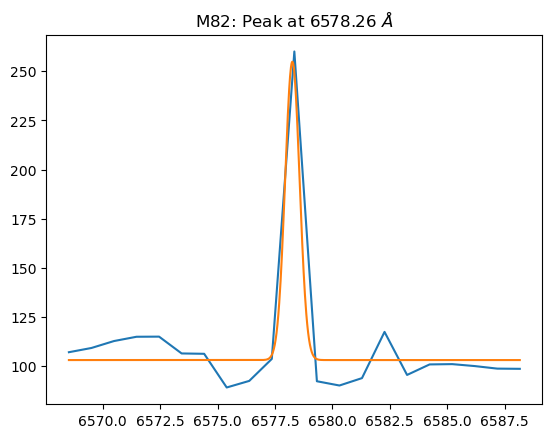

The stddev of the gaussian is 0.2277


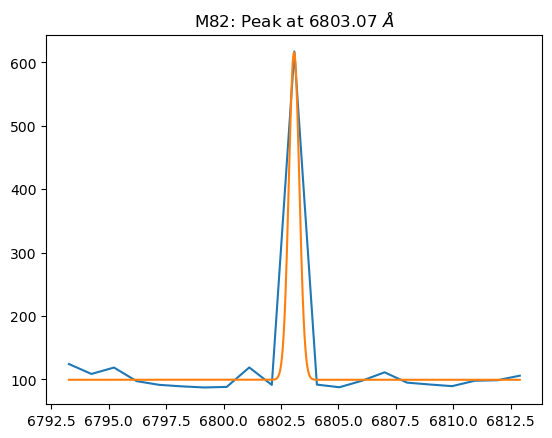

In [44]:
# Here we're going to fit gaussians to our peaks to find the uncertainty in our wavelength

from astropy.modeling import models, fitting

maxs = [355, 399, 628]
data = [m51_tot, m82_tot]
k = 0

for sets in data:
    for i in range(0, 3):
        r = sets[maxs[i]-10:maxs[i]+11]
        y1s = r[:5]
        y2s = r[16:]
        for j in range(len(y1s)):
            if y1s[j] >= 0.25*np.max(r):
                y1s[j] = np.mean(y1s)
            if y2s[j] >= 0.25 * np.max(r):
                y2s[j] = np.mean(y2s)

        ys = np.hstack((y1s, r[5:16], y2s))
        xs = wavelength_axis[maxs[i]-10:maxs[i]+11]

        amp = np.max(ys)
        mu = np.median(xs)
        g = models.Gaussian1D(amplitude=amp, mean=mu) + models.Const1D()
        fitter = fitting.LevMarLSQFitter()
        g_fit = fitter(g, xs, ys)
        amp, mean, stddev, c = g_fit.parameters
        x_values = np.linspace(xs[0], xs[-1], 1000)
        y_values = g_fit(x_values)
        print(f"The stddev of the gaussian is {stddev:.4f}")
        if k == 0:
            plt.title(rf"M51: Peak at {mean:.2f} $\AA$")
        elif k == 1:
            plt.title(rf"M82: Peak at {mean:.2f} $\AA$")
        plt.plot(xs, ys)
        plt.plot(x_values, y_values)
        plt.show()
    k += 1